# __Lock in Amplifier Using EXPEYES__

### Importing the Libraries

In [1]:
import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

W###################-------------


### Defining the Frequencies and Amplitude of the Input Signal

In [2]:
# function generator settings
f = 1000 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 8192
N_div=64
t_gap = (1/(f*N_div))*10**6 #us

# experimental settings
warmup = True
triggering = True
right_clip = True

In [3]:
print(f"f = {f} Hz")
print(f"amp = {amp} V")
print(f"N_sample = {N_sample}")
print(f"N_div = {N_div}")
print(f"t_gap = {t_gap} us")


f = 1000 Hz
amp = 2 V
N_sample = 8192
N_div = 64
t_gap = 15.625 us


### Setting the Input Signal as a sine wave of frequency 1000Hz

In [4]:
p.select_range('A1',2.5)
t,v = p.capture1('A1',N_sample,t_gap) # Captured input signal

t = np.array(t)
v = np.array(v)

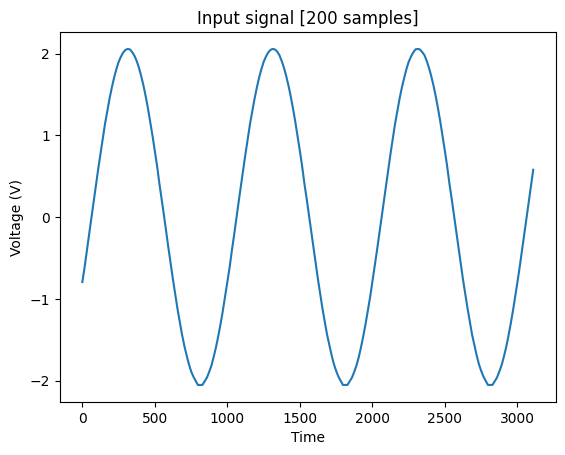

In [5]:
# plotting the input signal
cutoff = 200
plt.plot(t[:cutoff]*1000,v[:cutoff])
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title(f'Input signal [{cutoff} samples]')
plt.show()


In [6]:
def warmup_expeyes(t_gap):
    warmup_values = [100,500,1000,2000,4000]
    for val in range(4500,8001,500):
        warmup_values.append(val)
    for val in [8100,8190,8192]:
        warmup_values.append(val)
    for val in warmup_values:
        t,v, tt,vv = p.capture2(val, t_gap)

In [7]:
if warmup: warmup_expeyes(t_gap)
t,v, tt,vv = p.capture2(N_sample, t_gap)

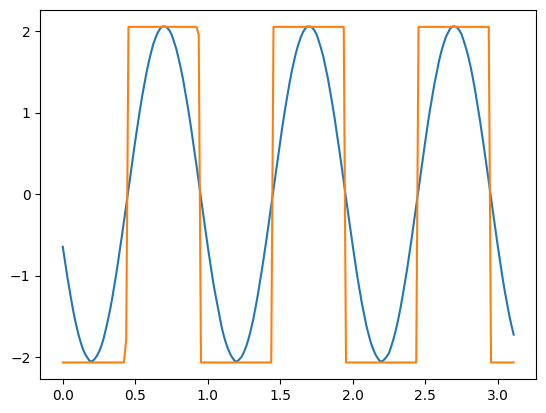

In [9]:
plt.plot(t[:200],v[:200])
plt.plot(tt[:200],vv[:200])
plt.show()

### Generating the Reference Signals (Sine and Cosine)

Trigger index = 19


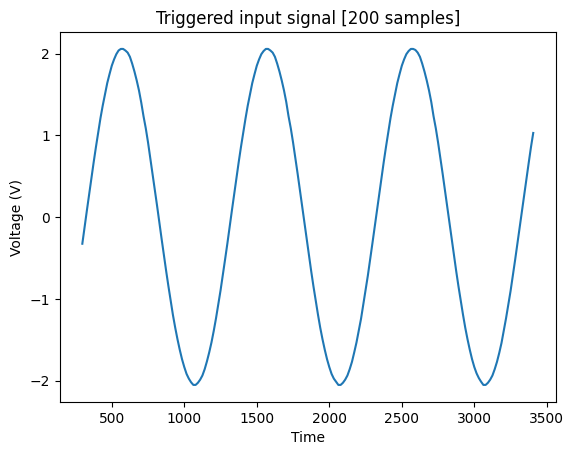

In [9]:
# trigger the reference signal vv by rising edge
def trigger(vv):
    for i in range(len(vv)-1):
        if vv[i] < 0 and vv[i+1] > 0:
            return i
    return i

if triggering:
    trigger_index = trigger(vv)
    print(f"Trigger index = {trigger_index}")

    triggered_t = t[trigger_index:]
    triggered_v = v[trigger_index:]
    triggered_vv = vv[trigger_index:]


# plotting the triggered input signal
cutoff = 200
plt.plot(triggered_t[:cutoff]*1000,triggered_v[:cutoff])
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title(f'Triggered input signal [{cutoff} samples]')
plt.show()

In [13]:
V_sin_ref=[]
V_cos_ref=[]
t_ref = []

curr_N_sample = len(triggered_v)
for i in range(curr_N_sample):
    V_sin_ref.append(amp*m.sin(2*m.pi*f*i*t_gap*10**-6))
    V_cos_ref.append(amp*m.cos(2*m.pi*f*i*t_gap*10**-6))
    t_ref.append(i*t_gap)

print(len(V_sin_ref))    


4981


### Plotting the Reference and the input signals

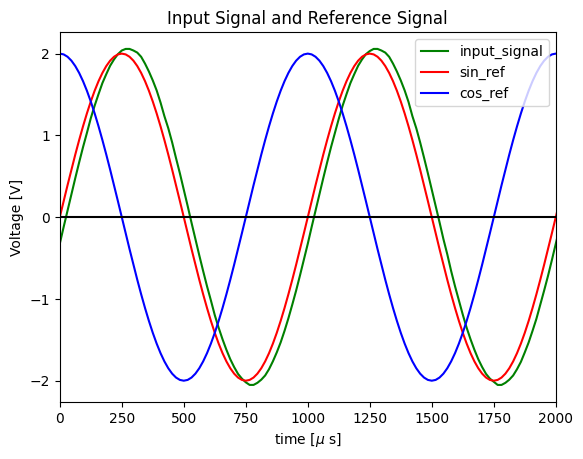

In [14]:
import matplotlib.pyplot as plt
plt.plot(t_ref,triggered_v,color='green',label='input_signal')
plt.plot(t_ref,V_sin_ref,color='red',label='sin_ref')
plt.plot(t_ref,V_cos_ref,color='blue',label='cos_ref')
plt.xlabel(r'time [$\mu $ s]')
plt.ylabel('Voltage [V]')
plt.xlim(0,2000)
plt.legend()
plt.title('Input Signal and Reference Signal')
plt.axhline(y=0, c="black")
plt.show()

### Phase matching (Multipling the input with sin)

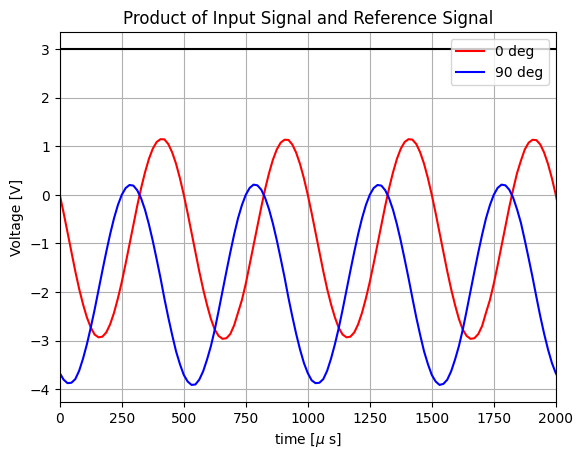

In [16]:
v_pm_sin = []
v_pm_cos = []
for i in range(curr_N_sample):
    v_pm_sin.append(v[i]*V_sin_ref[i])
    v_pm_cos.append(v[i]*V_cos_ref[i])

import matplotlib.pyplot as plt_pm
plt_pm.plot(t_ref,v_pm_sin,color='red',label='0 deg')
plt_pm.plot(t_ref,v_pm_cos,color='blue',label='90 deg')
plt_pm.xlabel(r'time [$\mu $ s]')
plt_pm.title('Product of Input Signal and Reference Signal')
plt_pm.ylabel('Voltage [V]')
plt_pm.xlim(0,2000)
plt_pm.legend()
plt_pm.axhline(y=3, c="black")
plt.grid()
plt_pm.show()


### Taking FFT for Low Pass Filter

In [20]:
freq=fftfreq(curr_N_sample,(t[1]-t[0])*0.001)
sine_fft=fft(v_pm_sin)
cos_fft=fft(v_pm_cos)

### Plotting the Sine wave in the frequency domain

c:\Users\Dell\Desktop\adhil-anagha_expeyes\Lockin_expeyes\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


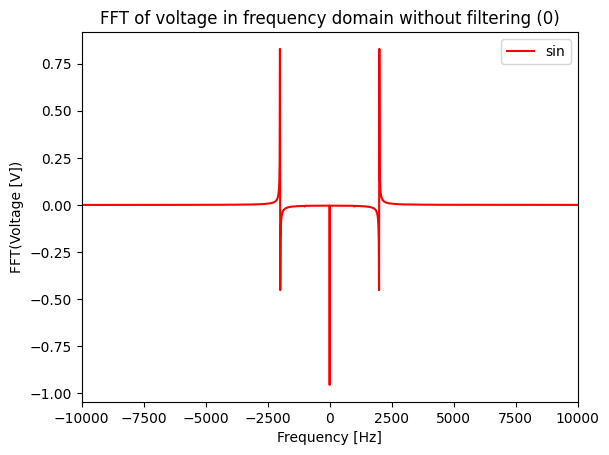

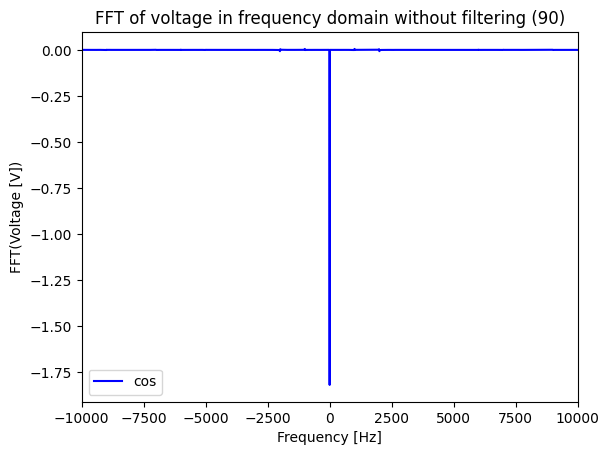

In [21]:
xf = fftshift(freq)
yplot = (1/curr_N_sample) * fftshift(sine_fft)


import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='red',label='sin')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (0)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()

yplot = (1/curr_N_sample) * fftshift(cos_fft)

import matplotlib.pyplot as plt_fft
plt_fft.plot(xf,(yplot),color='blue',label='cos')
plt_fft.xlabel(r'Frequency [Hz]')
plt_fft.ylabel('FFT(Voltage [V])')
plt_fft.title('FFT of voltage in frequency domain without filtering (90)')
plt_fft.xlim(-10000,10000)
plt_fft.legend()
plt_fft.show()


### Calculating the Voltages

In [22]:
print("X component of the output Voltage",sine_fft[0].real/len(sine_fft))
print("Y component of the Output Voltage",cos_fft[0].real/len(cos_fft))
print("Voltage is",np.sqrt((sine_fft[0].real/len(sine_fft))**2+(cos_fft[0].real/len(cos_fft))**2),"V")

print("Phase of the output Voltage",m.atan((cos_fft[0].real/len(cos_fft))/(sine_fft[0].real/len(sine_fft)))*180/m.pi,"deg")

X component of the output Voltage -0.9552949210617373
Y component of the Output Voltage -1.8188284581664043
Voltage is 2.0544403973934924 V
Phase of the output Voltage 62.290403689221925 deg


### Single run

In [23]:
# import libraries

import eyes17.eyes
import numpy as np
import math as m
import time
from scipy.fft import fft, ifft,fftfreq, fftshift
import matplotlib.pyplot as plt

p=eyes17.eyes.open()

# required functions

def warmup_expeyes(t_gap):
    warmup_values = []
    # warmup_values = [100,500,1000,2000,4000]
    for val in range(4500,8001,500):
        warmup_values.append(val)
    for val in [8100,8190,8192]:
        warmup_values.append(val)
    for val in warmup_values:
        t,v, tt,vv = p.capture2(val, t_gap)


# function generator settings

f = 1000 #Hz
amp = 2 #V

# expeyes17 settings
N_sample = 8192
N_div=64
t_gap = (1/(f*N_div))*10**6 #us

# experimental settings
warmup = True
warmup_repititive = False

plot = True
plot_cutoff = 1

# internal settings dont touch!
warmup_flag = 0

print("settings ready!")

W###################-------------
Device opening Error
settings ready!


Performing a warmup run.. coz the Expeyes misbehaving otherwise!


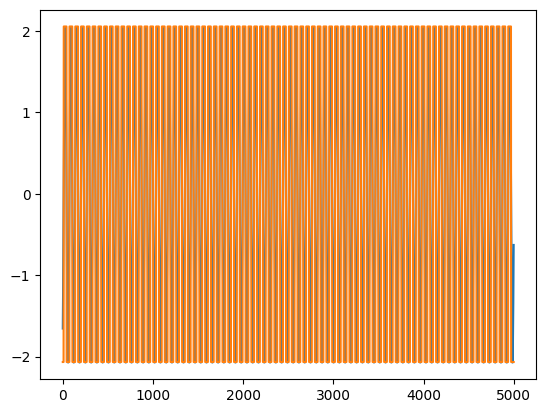

In [2]:
if warmup and warmup_flag == 0: 
    if warmup_repititive: print("Performing repititive warmup...")
    else: print("Performing a warmup run.. coz the Expeyes misbehaving otherwise!")
        
    warmup_expeyes(t_gap)
    warmup_flag = 1
elif not warmup:
    print("NO WARMuP.. POSSIBLE FAILURE OF CAPTURE2...")
t,v, tt,vv = p.capture2(N_sample, t_gap)

v= np.array(v)
vv = np.array(vv)

if plot:
    cutoff_index = int(len(v) * plot_cutoff)
    plt.plot(v[:cutoff_index])
    plt.plot(vv[:cutoff_index])